In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib

random forest models modified. changed criterion to absolute error

In [2]:
def add_t_minus(df, n):
    if n == 0:
        return df
    df_res = df.copy()
    for i in range(1,n+1):
        df_shifted = df.shift(i)
        for cname in df_shifted.columns:
            df_shifted.rename(columns = {cname:cname+'_'+str(i)}, inplace = True)
        df_res = df_res.join(df_shifted)
    df_res = df_res.interpolate(method='spline', limit_direction='backward', order=1)
    return df_res

def preprocess_data(features, labels=None, tminus=0):

    if labels is not None:
        features = features.join(labels)

    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)
    features = features.interpolate(method="spline", order=1)
    
    
    if labels is not None:
        nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        nfeatures['prev_total_cases'] = features['total_cases'].shift(1).fillna(0)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features, tminus)

def get_data(features_path, labels_path=None, tminus=0):
    if labels_path is not None:
        labels = pd.read_csv(labels_path,
                           index_col=[0,1,2])

    features = pd.read_csv(features_path,
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

    # Separate data for San Juan
    sj_features = features.loc['sj']
    if labels_path is not None:
        sj_labels = labels.loc['sj']

    # Separate data for Iquitos
    iq_features = features.loc['iq']
    if labels_path is not None:
        iq_labels = labels.loc['iq']

    if labels_path is not None:
        sj_f, sj_l = preprocess_data(sj_features, sj_labels, tminus)
        iq_f, iq_l = preprocess_data(iq_features, iq_labels, tminus)
        return sj_f, sj_l, iq_f, iq_l

    return preprocess_data(sj_features, None, tminus), preprocess_data(iq_features, None, tminus)


In [3]:
tminus = 0
sj_X_train, sj_y_train, iq_X_train, iq_y_train = get_data('dengue_features_train.csv',
                                                        'dengue_labels_train.csv',tminus=tminus)

# load the provided data
train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

# Separate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

sj_X_train, sj_y_train = preprocess_data(sj_train_features,sj_train_labels)

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

iq_X_train, iq_y_train = preprocess_data(iq_train_features,iq_train_labels)

In [4]:
#split data in train and test
sj_X_train, sj_X_test, sj_y_train, sj_y_test = train_test_split(
    sj_X_train, sj_y_train, test_size=0.3, shuffle=False)

iq_X_train, iq_X_test, iq_y_train, iq_y_test = train_test_split(
iq_X_train, iq_y_train, test_size=0.3, shuffle=False)


In [5]:
sj_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,655.0,26.810687,14.858483,1.000000,14.000000,27.000000,40.000000,53.000000
ndvi_ne,655.0,0.085308,0.085051,-0.290200,0.042304,0.082313,0.120275,0.446267
ndvi_nw,655.0,0.096682,0.078717,-0.130950,0.050250,0.090200,0.134000,0.437100
ndvi_se,655.0,0.181044,0.054837,0.036000,0.146207,0.178579,0.212529,0.393129
ndvi_sw,655.0,0.168472,0.055406,-0.063457,0.134221,0.169529,0.203043,0.381420
...,...,...,...,...,...,...,...,...
station_diur_temp_rng_c_8,655.0,6.870693,0.820428,4.528571,6.371429,6.871429,7.385714,9.914286
station_max_temp_c_8,655.0,31.697876,1.634533,27.200000,30.600000,31.700000,32.800000,35.600000
station_min_temp_c_8,655.0,22.577539,1.483195,17.800000,21.700000,22.800000,23.900000,25.600000
station_precip_mm_8,655.0,25.436964,27.646948,0.000000,6.600000,16.800000,33.750000,305.900000


In [6]:
iq_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,364.0,26.431319,14.973924,1.000000,13.750000,26.000000,39.000000,53.000000
ndvi_ne,364.0,0.267275,0.080754,0.090057,0.205348,0.267742,0.323432,0.488400
ndvi_nw,364.0,0.234158,0.075866,0.035860,0.178618,0.227623,0.289986,0.428771
ndvi_se,364.0,0.251609,0.076012,0.029880,0.195429,0.250836,0.305218,0.473400
ndvi_sw,364.0,0.264409,0.083300,0.064183,0.207045,0.262350,0.321064,0.546017
...,...,...,...,...,...,...,...,...
station_diur_temp_rng_c_8,364.0,10.527288,1.471891,5.200000,9.500000,10.450000,11.568750,15.800000
station_max_temp_c_8,364.0,33.926699,1.278726,30.100000,33.200000,33.900000,34.600000,42.200000
station_min_temp_c_8,364.0,21.171531,1.377104,14.700000,20.500000,21.400000,22.118377,24.200000
station_precip_mm_8,364.0,62.064760,81.322386,-416.914865,18.225000,54.000000,90.375000,543.300000


In [7]:
# compute the correlations
sj_correlations = sj_X_train.corr()
iq_correlations = iq_X_train.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

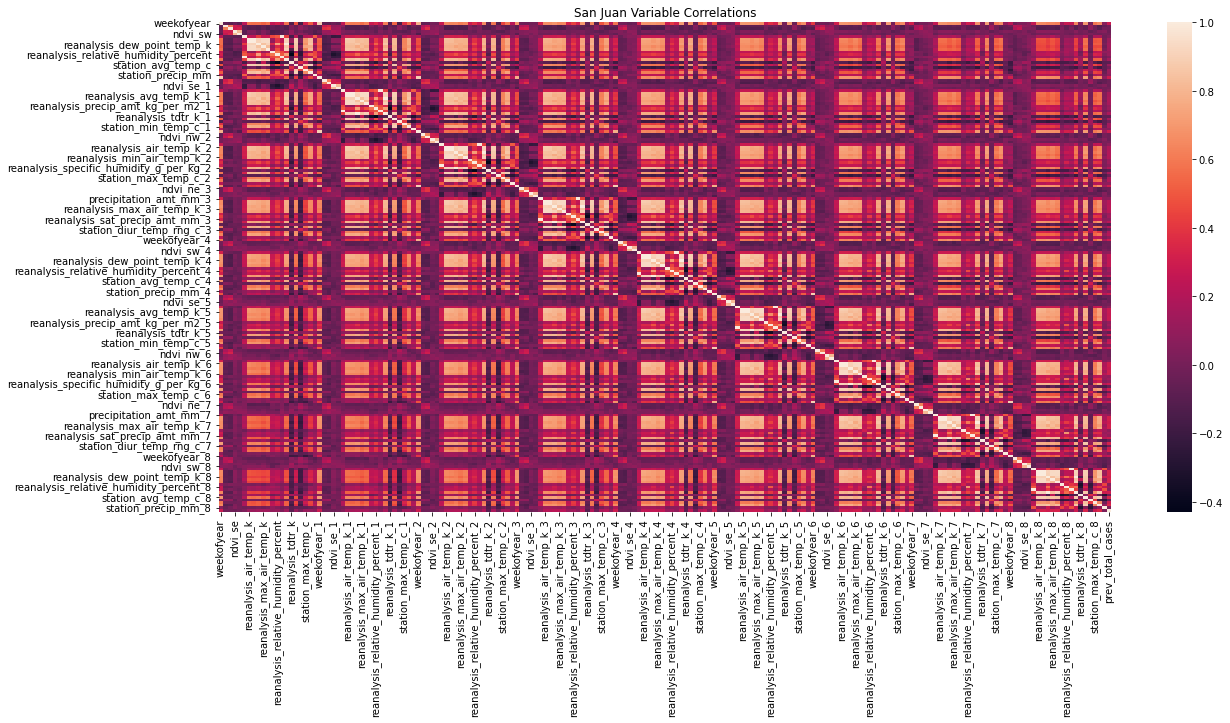

In [8]:
plt.rcParams["figure.figsize"] = (20,9)

# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

In [9]:
'''def chain_predict(model,x):
    #need to used last predicted y as input for next prediction
    xt = x.copy()
    preds = []
    #ser previous cases to zero
    xt['prev_total_cases'] = 0.0
    #make first prediction taking preset zero 
    #an update next column with prediction

    for i in range(xt.shape[0]):
        yt = model.predict([xt.iloc[i]])
        if i+1 < xt.shape[0]:
            xt['prev_total_cases'].iloc[i+1] = yt
        preds.append(yt[0])

    return preds'''

"def chain_predict(model,x):\n    #need to used last predicted y as input for next prediction\n    xt = x.copy()\n    preds = []\n    #ser previous cases to zero\n    xt['prev_total_cases'] = 0.0\n    #make first prediction taking preset zero \n    #an update next column with prediction\n\n    for i in range(xt.shape[0]):\n        yt = model.predict([xt.iloc[i]])\n        if i+1 < xt.shape[0]:\n            xt['prev_total_cases'].iloc[i+1] = yt\n        preds.append(yt[0])\n\n    return preds"

In [10]:
'''sj_rf = RandomForestRegressor(  n_estimators = 100, 
                                min_samples_leaf=25, 
                                criterion='absolute_error',
                                max_depth = 4)'''

sj_rf = RandomForestRegressor(  n_estimators = 100,
                                min_samples_leaf=5,
                                criterion='squared_error',
                                )                               
sj_rf.fit(sj_X_train, sj_y_train)
print(mean_absolute_error(sj_y_train, sj_rf.predict(sj_X_train)))
print(mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))

4.679739149310946
6.803125046979169


In [11]:
sj_rf.feature_importances_

array([1.65606927e-05, 5.07193372e-05, 7.76320486e-04, 1.20261646e-04,
       3.84202096e-04, 1.14558571e-04, 4.41754180e-05, 9.03200938e-05,
       1.21217328e-04, 6.32886732e-05, 5.33534358e-05, 2.54402810e-03,
       2.36051377e-04, 5.45307087e-05, 6.93326798e-05, 2.05325142e-04,
       1.43850028e-04, 2.21562131e-04, 2.31458225e-04, 1.99050123e-04,
       1.61806639e-04, 4.49767612e-05, 6.67382019e-03, 1.25929792e-02,
       1.31442772e-04, 2.03109804e-04, 1.03408782e-04, 1.56478346e-05,
       6.34295552e-05, 6.00976595e-05, 8.88207623e-05, 4.61651183e-05,
       1.14380814e-04, 4.97235801e-05, 1.25796922e-04, 1.58018926e-05,
       1.03178921e-04, 5.17298394e-05, 1.35674941e-04, 2.33442945e-05,
       1.67919965e-04, 2.40686498e-04, 9.15724573e-05, 2.41567449e-04,
       8.45126331e-05, 4.30740151e-04, 3.09605234e-04, 1.30808744e-04,
       3.51677138e-05, 1.50358495e-05, 4.95550863e-04, 6.65656491e-05,
       2.19151112e-04, 1.23877289e-04, 1.01459114e-04, 7.05718969e-04,
      

<AxesSubplot:ylabel='cols'>

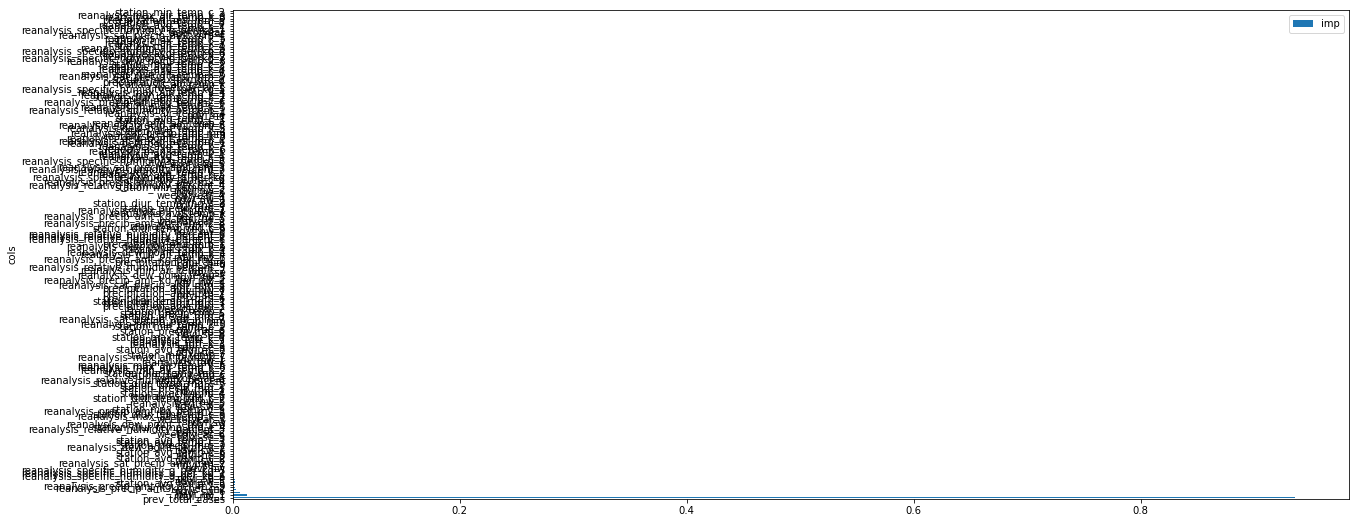

In [12]:
plt.rcParams["figure.figsize"] = (20,9)
(pd.DataFrame(dict(cols=sj_X_train.columns, imp=sj_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

In [13]:
iq_rf =  RandomForestRegressor( n_estimators = 100, 
                                min_samples_leaf=5, 
                                criterion='squared_error',
                                )

'''iq_rf = RandomForestRegressor(  n_estimators = 100,
                                min_samples_leaf=25,
                                criterion='absolute_error',)  '''
iq_rf.fit(iq_X_train, iq_y_train)
print(mean_absolute_error(iq_y_train, iq_rf.predict(iq_X_train)))
print(mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

2.101399156515871
4.751089199272188


In [14]:
iq_rf.feature_importances_

array([3.81449469e-03, 2.92138323e-04, 1.62790970e-03, 6.85095278e-04,
       4.35629864e-03, 1.93559893e-04, 3.58991741e-04, 2.88019290e-04,
       1.01026731e-03, 1.50746456e-04, 4.11581955e-04, 5.22719056e-04,
       7.89147853e-04, 1.44309120e-04, 1.01301719e-03, 7.32741479e-04,
       1.54198244e-04, 2.06654344e-03, 1.06939204e-03, 1.19665268e-03,
       3.28257408e-04, 8.43474014e-04, 9.11190164e-03, 8.74398006e-04,
       5.05558879e-04, 1.51113877e-04, 1.37723898e-03, 7.28509208e-04,
       4.87015880e-04, 4.82637326e-04, 8.42044760e-03, 1.33901989e-03,
       2.47996776e-04, 9.63699720e-04, 1.89741772e-03, 3.39917409e-04,
       2.52605577e-04, 6.37806770e-04, 1.24439007e-03, 4.65338482e-04,
       2.20224584e-03, 7.89964747e-03, 1.94336247e-03, 2.42630509e-03,
       5.77393254e-04, 5.16514576e-04, 2.94169704e-04, 3.11526048e-03,
       6.73744008e-04, 5.73392080e-04, 9.40936031e-04, 9.38940221e-04,
       4.47426108e-03, 1.24473369e-03, 4.90249472e-04, 3.42024206e-03,
      

<AxesSubplot:ylabel='cols'>

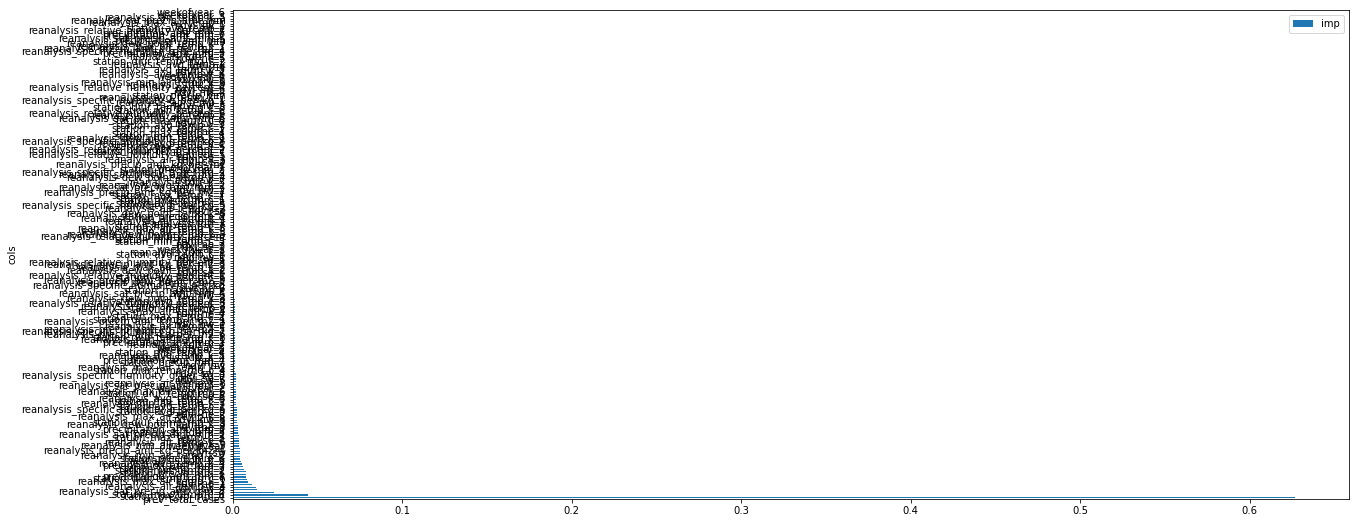

In [15]:
plt.rcParams["figure.figsize"] = (20,9)
(pd.DataFrame(dict(cols=iq_X_train.columns, imp=iq_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

In [16]:
#open pretrained models without cases as feature
sj_model = joblib.load('sj_rf.pkl')
iq_model = joblib.load('iq_rf.pkl')

In [17]:
sj_X_test['prev_total_cases'] = sj_model.predict(sj_X_test.drop('prev_total_cases', axis=1))
sj_X_test['prev_total_cases'] = (sj_X_test['prev_total_cases']
                                    .shift(1)
                                    .fillna(0))

iq_X_test['prev_total_cases'] = iq_model.predict(iq_X_test.drop('prev_total_cases', axis=1))
iq_X_test['prev_total_cases'] = (iq_X_test['prev_total_cases']
                                    .shift(1)
                                    .fillna(0))


/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- ndvi_ne_1
- ndvi_ne_2
- ndvi_ne_3
- ndvi_ne_4
- ndvi_ne_5
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 189 features, but RandomForestRegressor is expecting 21 features as input.

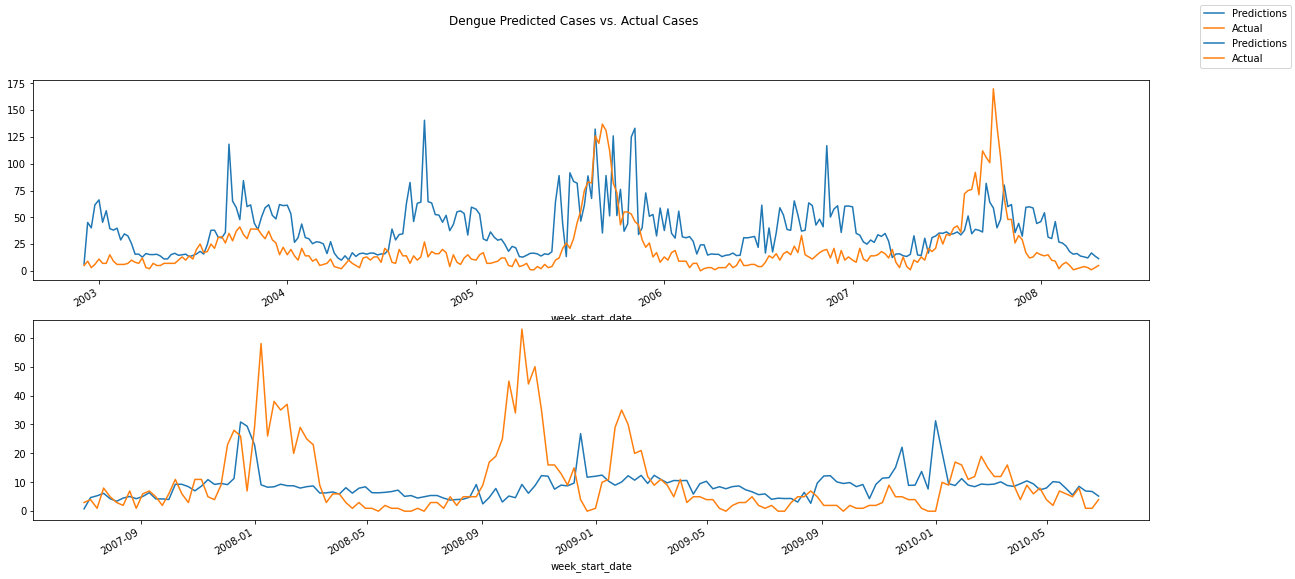

In [ ]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_X_test['fitted'] = sj_rf.predict(sj_X_test)
sj_X_test.fitted.plot(ax=axes[0], label="Predictions")
sj_y_test.plot(ax=axes[0], label="Actual")

iq_X_test['fitted'] = iq_rf.predict(iq_X_test)
iq_X_test.fitted.plot(ax=axes[1], label="Predictions")
iq_y_test.plot(ax=axes[1], label="Actual")

figs.suptitle("Dengue Predicted Cases vs. Actual Cases")
figs.legend()

In [ ]:
sj_X_test.drop('fitted',axis=1,inplace=True)
iq_X_test.drop('fitted',axis=1,inplace=True)

In [ ]:
#submit data
sj_X_valid, iq_X_valid = get_data('dengue_features_test.csv',tminus=tminus) 

In [ ]:
sj_X_valid

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,18,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
2008-05-06,19,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2008-05-13,20,-0.001500,0.061357,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
2008-05-20,21,0.072478,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
2008-05-27,22,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-26,13,-0.087400,-0.016183,0.156343,0.105186,30.34,298.670000,298.885714,294.675714,301.3,...,2.55,78.780000,30.34,15.985714,3.314286,27.542857,7.942857,33.9,22.8,3.5
2013-04-02,14,-0.203250,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,301.5,...,64.30,81.650000,6.55,15.881429,2.828571,26.642857,6.642857,33.3,22.8,17.6
2013-04-09,15,-0.117600,-0.008200,0.192700,0.170429,0.00,299.057143,299.328571,294.948571,301.5,...,0.70,78.285714,0.00,16.212857,3.171429,27.914286,8.114286,32.8,23.3,9.4


In [ ]:
iq_X_valid

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,26,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,296.118571,307.9,...,34.11,92.581429,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2
2010-07-09,27,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,294.831429,307.7,...,9.10,83.885714,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9
2010-07-16,28,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,296.417143,306.4,...,61.09,92.057143,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6
2010-07-23,29,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,293.638571,306.4,...,19.60,88.970000,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8
2010-07-30,30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,293.892857,308.1,...,18.93,78.610000,56.30,15.468571,11.771429,27.050,11.850,33.5,16.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,22,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,...,67.60,89.990000,41.12,17.185714,10.100000,27.400,9.050,32.6,21.8,33.0
2013-06-04,23,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,...,45.70,93.891429,71.52,17.448571,9.657143,27.520,10.720,33.8,21.4,68.0
2013-06-11,24,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,...,45.22,94.967143,78.96,16.410000,7.385714,27.200,10.075,32.6,21.6,93.2


In [ ]:
sj_predictions = sj_rf.predict(sj_X_valid).astype(int)
iq_predictions = iq_rf.predict(iq_X_valid).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark.csv")

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- prev_total_cases

  warnings.warn(message, FutureWarning)


ValueError: X has 21 features, but RandomForestRegressor is expecting 22 features as input.

In [ ]:
print('sj', mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))
print('iq', mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

sj 24.588195131952656
iq 7.8553061858129425


week_start_date
2002-12-03    0.0
2002-12-10    5.0
2002-12-17    9.0
2002-12-24    3.0
2003-01-01    6.0
             ... 
2008-03-25    3.0
2008-04-01    4.0
2008-04-08    3.0
2008-04-15    1.0
2008-04-22    3.0
Name: total_cases, Length: 281, dtype: float64

In [ ]:
sj_y_test

week_start_date
2002-12-03     5
2002-12-10     9
2002-12-17     3
2002-12-24     6
2003-01-01    11
              ..
2008-03-25     4
2008-04-01     3
2008-04-08     1
2008-04-15     3
2008-04-22     5
Name: total_cases, Length: 281, dtype: int64